# Split-Operator Methods for Numerical Physics

Solving PDEs (Schrodinger equation) using the split operator methods. 
Both split operator techniques are used to deal with
non-commuting operators in the exponential argument, generally due to 
time-evolution of a wavefunction. This is treated first by a Taylor expansion
and clever algebraic manipulation to turn an expression exp(A+B) into 
exp(A/2)exp(B)exp(A/2). The Baker-Campbell-Hausdorff lemma can also be used to
split the exponential operator.

The next step depends on the type of technique to be implemented. The general 
split step operation requires that an explicit basis change is performed for one
of the two operators in the sequence. As solutions are frequently displayed in 
position space, the momentum operator is chosen to undergo a basis change.
The momentum matrix is diagonalized and applied in sequence with its unitary
transformation matrices to act on the initial wavefunction. This is done 
iteratively over time to compute the wavefunction at every time step.

The second method involves using the Fast Fourier Transform (FFT) algorithm to
change the space we are working in to properly apply the momentum operator. 
This is identical to a basis change but is much faster than a diagonalization
procedure. The first potential operator acts on the initial wavefunction, then
it is FFT'd into momentum (k) space, where the momentum operator in its own
basis is not a derivative, but a multiplication. Then, after the operation, the
resultant is IFFT'd back into position space, where the second potential term
acts on the rest of the operation. This is done iteratively over time to 
compute the wavefunction at every time step.

This code can solve time dependent and time-independent QHO potentials by 
editing the value of the angular frequency. If a time-independent potential is to
be used, please edit the w variable so that it is an integer and not an array.
If a time-dependent potential is to be used, please edit the w variable so that
it is an array and not an integer.

In this code two cases are solved: arbitrary and Gaussian wavefunctions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import NumMethods as nm
from SplitOps import *

## Arbitrary wavepacket in QHO

In [24]:
###############################################################################
## Using Split Operator Methods to Evolve Wavefunction in QHO
###############################################################################
# Evolution of arbitrary wavefunction composed of linear combination of energy 
# eigenfunctions in Quantum Harmonic Oscillator (QHO)

print("Solving time-dependent QHO for arbitrary wavefunction"
      " composed of energy eigenfunctions.")

"""#### Defining Parameters ####"""
N=750 # Number of space points
L=10 # Width being solved over
x=np.linspace(-L,L,N) # Grid of space points
dx=x[1]-x[0] # Spatial step
nt=100 # Number of time points
t=np.linspace(0,10,nt) # Grid of time points
dt=t[1]-t[0] # Time step
dk=2*np.pi/(N*dx) # spectral step
k=np.arange(-(N-1)*dk/2,N*dk/2,dk) # Grid of k-space

"""#### Wavefunction and Potential Parameters ####"""
# Frequency of harmonic oscillator potential
w0=1 # Time-independent potential

# Eigenfunctions of QHO (Hermite polynomials)
wfxn0=np.exp(-w0*0.5*x**2)
wfxn1=np.sqrt(2*w0)*x*wfxn0
wfxn2=(1/np.sqrt(2))*(2*w0*x**2-1)*wfxn0
wfxn3=(1/(np.sqrt(3))*(2*np.sqrt(w0)**3*x**3-3*np.sqrt(w0)*x))*wfxn0
# Initial wavefunction
wfxn=(1/np.sqrt(3))*(wfxn1+wfxn2+wfxn3)

print("Normalizing wavefunction...")
S=nm.simpson(N,x,wfxn*np.conj(wfxn),-L,L)
A=1/np.sqrt(S)
wfxn=A*wfxn

# Harmonic Oscillator potential 
# np.outer used to generate matrix (outer product) if time-dependent
V=0.5*w0**2*x**2

# Energy expectation value
avg_H=expect_H(wfxn,L,w0,x,N)
print("Average over expectation values of H, <H>:",'{:,.5}'.format(np.average(avg_H)))

print("Number of points in space, N:", N)
print("Number of points in time, nt:", nt)
print("Spatial step size, dx:",'{:,.5}'.format(dx))
print("Temporal step size, dt:", '{:,.5}'.format(dt))
print("Spectral step size, dk:",'{:,.5}'.format(dk))

"""#### True Solution ####"""

n=np.array([0,1,2,3])
En=w0*(n+0.5)

wfxn_true=np.zeros([len(x),len(t)],dtype=complex)
wfxn_true[:,0]=wfxn

for i in range(len(t)-1):
    wfxn_true[:,i+1]=(1/np.sqrt(4))*(np.exp(-1j*En[0]*t[i])*wfxn0
                    +np.exp(-1j*En[1]*t[i])*wfxn1
                    +np.exp(-1j*En[2]*t[i])*wfxn2+np.exp(-1j*En[3]*t[i])*wfxn3)

# Normalization
print("Normalizing true solution...")
S=nm.simpson(N,x,wfxn_true[:,-1]*np.conj(wfxn_true[:,-1]),-L,L)
A=1/np.sqrt(S)
wfxn_true=A*wfxn_true


Solving time-dependent QHO for arbitrary wavefunction composed of energy eigenfunctions.
Normalizing wavefunction...
Average over expectation values of V, <V>: 1.6582
Expectation value of T, <T>: 0.84381
Average over expectation values of H, <H>: 2.5021
Number of points in space, N: 750
Number of points in time, nt: 100
Spatial step size, dx: 0.026702
Temporal step size, dt: 0.10101
Spectral step size, dk: 0.31374
Normalizing true solution...


### General Split Operator

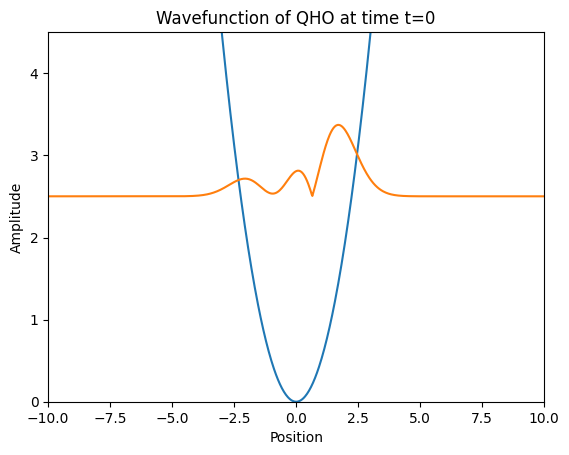

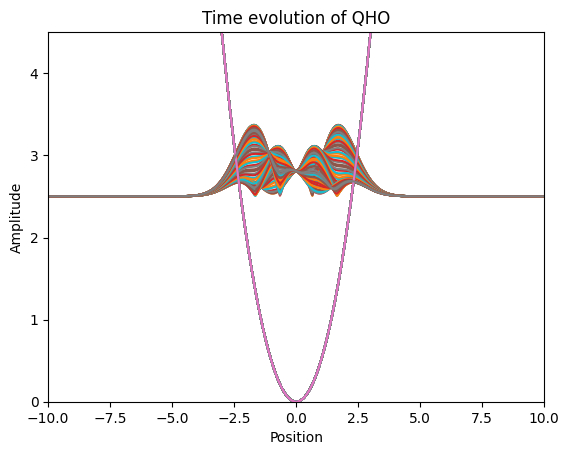

Checking if wfxn is still normalized...
Total probability: 1.0


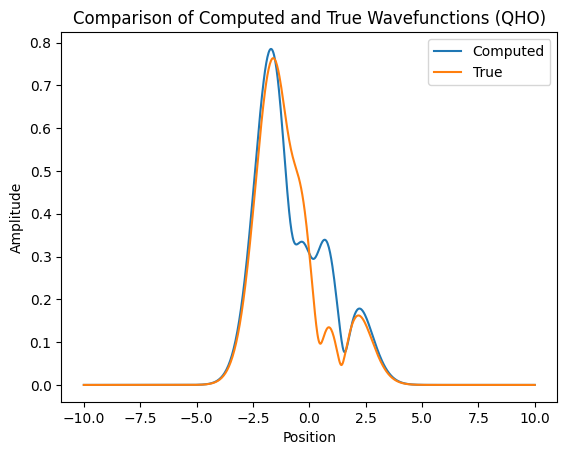

In [25]:
"""#### General Split Operator Method ####"""

# Applying general Split Operator method to solve TDSE

# Setting up kinetic energy matrix
# 3-pt formula for second derivative
lower_diag = np.ones(N-1)
main_diag = -2*np.ones(N) 
upper_diag = np.ones(N-1)
Tfac=1/(dx**2)

T=-0.5*Tfac*nm.tridiag(lower_diag,main_diag,upper_diag)
U,exp_T=DiagForm(T,dt)

# Allocating and initializing wavefunction
wfxn_sol=np.zeros([N,nt],dtype=complex)
wfxn_sol[:,0]=wfxn

# Solving TDSE using split operator
for j in range(nt-1):
    wfxn_sol[:,j+1]=SplitOp(V,exp_T,U,wfxn_sol[:,j],dt)

# Displaying results #

# Plotting initial wavefunction inside initial potential
plt.figure()
wfxnPlot(V,wfxn_sol[:,0],x,L,avg_H)
plt.title('Wavefunction of QHO at time t=0')
plt.show()

# Plotting all timesteps at once on the same plot
plt.figure()
for j in range(nt-1):
    wfxnPlot(V,wfxn_sol[:,j],x,L,avg_H)
    plt.title('Time evolution of QHO')
plt.show()

# Checking if time-evolution retained normalization of function at the end
# This allows us to validate the model and ensure it is not broken
print(r"Checking if wfxn is still normalized...")
S=nm.simpson(N,x,wfxn_sol[:,-1]*np.conj(wfxn_sol[:,-1]),-L,L)
print("Total probability:",'{:,.5}'.format(np.real(S)))

# Plotting true solutions with computed solutions
eigenQHO(x,t,wfxn_sol,wfxn_true)

### FFT Split Operator

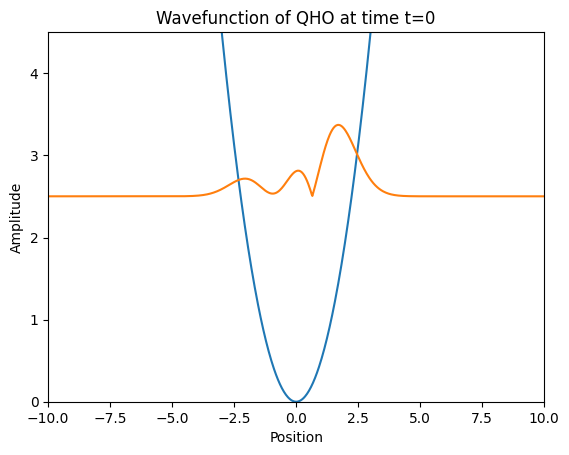

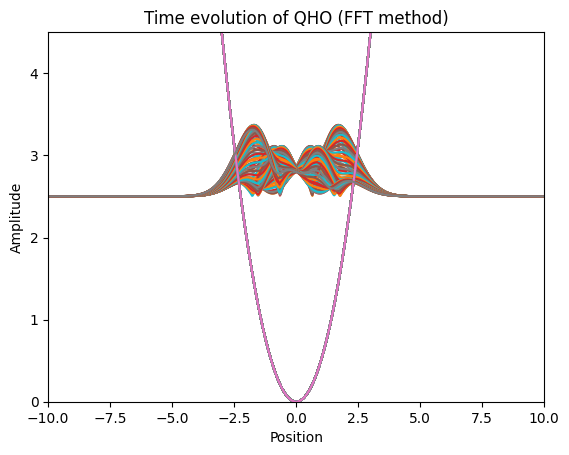

Checking if wfxn is still normalized...
Total probability: 1.0


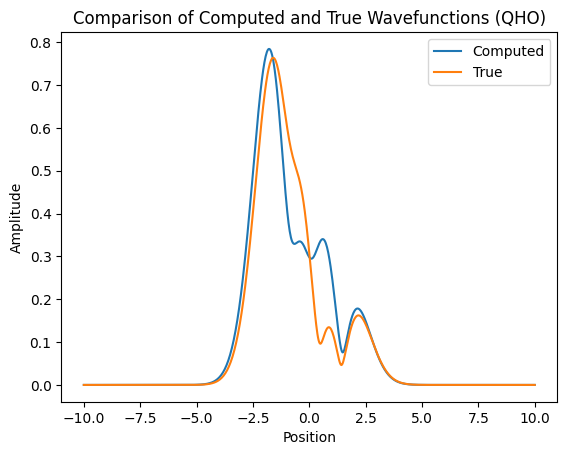

In [4]:
# Applying FFT Split Operator method to solve TDSE

# Defining kinetic energy in k-space
exp_k=np.exp(-0.5j*dt*k**2)

# Allocating and initializing wavefunction
wfxn_sol=np.zeros([N,nt],dtype=complex)
wfxn_sol[:,0]=wfxn

# Solving TDSE using fft split operator
for j in range(nt-1):
    wfxn_sol[:,j+1]=SplitFFT(V,exp_k,wfxn_sol[:,j],dt)

# Displaying results #

# Plotting initial wavefunction inside initial potential
plt.figure()
wfxnPlot(V,wfxn_sol[:,0],x,L,avg_H)
plt.title('Wavefunction of QHO at time t=0')
plt.show()

# Plotting all timesteps at once on the same plot
plt.figure()
for j in range(nt-1):
    wfxnPlot(V,wfxn_sol[:,j],x,L,avg_H)
    plt.title('Time evolution of QHO (FFT method)')
plt.show()

# Checking if time-evolution retained normalization of function at the end
# This allows us to validate the model and ensure it is not broken
print(r"Checking if wfxn is still normalized...")
S=nm.simpson(N,x,wfxn_sol[:,-1]*np.conj(wfxn_sol[:,-1]),-L,L)
print("Total probability:",'{:,.5}'.format(np.real(S)))

# Plotting true solutions with computed solutions
eigenQHO(x,t,wfxn_sol,wfxn_true)


## Gaussian Wavepacket in QHO

In [9]:
###############################################################################
## Using Split Operator Methods to Evolve Wavefunction in QHO
###############################################################################
# Evolution of Gaussian wavepacket in Quantum Harmonic Oscillator (QHO)

print("Solving time-dependent QHO for Gaussian wavefunction.")

"""#### Defining Parameters ####"""
N=257 # Number of space points
L=10 # Width being solved over
x=np.linspace(-L,L,N) # Grid of space points
dx=x[1]-x[0] # Spatial step
nt=100 # Number of time points
t=np.linspace(0,10,nt) # Grid of time points
dt=t[1]-t[0] # Time step
dk=2*np.pi/(N*dx) # spectral step
k=np.arange(-(N-1)*dk/2,N*dk/2,dk) # Grid of k-space

"""#### Wavefunction and Potential Parameters ####"""
p0=2 # Initial momentum of wavepacket
sigma=0.4 # Initial width of wavepacket
div=1/((2*np.pi*sigma**2)**0.25) # Constants bunched together 

# Initial wavefunction
wfxn=np.exp(1j*p0*x)*np.exp((-x**2)/((2*sigma)**2))*div

print("Normalizing wavefunction...")
S=nm.simpson(N,x,wfxn*np.conj(wfxn),-L,L)
A=1/np.sqrt(S)
wfxn=A*wfxn



Solving time-dependent QHO for Gaussian wavefunction.
Normalizing wavefunction...


In [10]:
# Frequency of harmonic oscillator potential
### Please edit these two lines below (comment/uncomment) ###
w=1+0.1*t # Time-dependent potential
# w=1 # Time-independent potential
### End user edits ###

In [11]:
# Harmonic Oscillator potential 
# np.outer used to generate matrix (outer product) if time-dependent
V=0.5*np.outer(w**2,x**2)

avg_H=expect_H(wfxn,L,w,x,N)
print("Average over expectation values of H, <H>:",'{:,.5}'.format(np.average(avg_H)))

print("Number of points in space, N:", N)
print("Number of points in time, nt:", nt)
print("Spatial step size, dx:",'{:,.5}'.format(dx))
print("Temporal step size, dt:", '{:,.5}'.format(dt))
print("Spectral step size, dk:",'{:,.5}'.format(dk))

Average over expectation values of V, <V>: 0.1868
Expectation value of T, <T>: 2.7876
Average over expectation values of H, <H>: 2.9744
Number of points in space, N: 257
Number of points in time, nt: 100
Spatial step size, dx: 0.078125
Temporal step size, dt: 0.10101
Spectral step size, dk: 0.31294


### General Split Operator

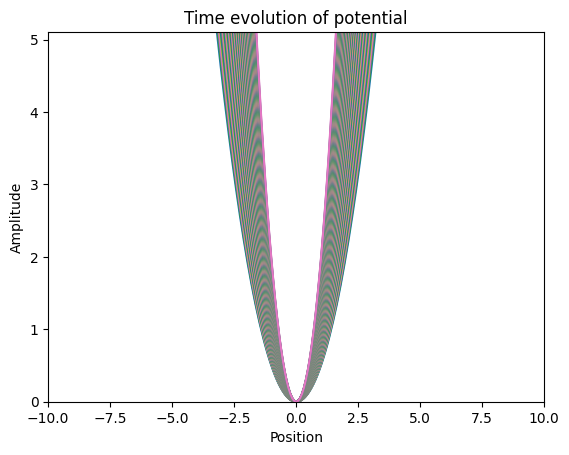

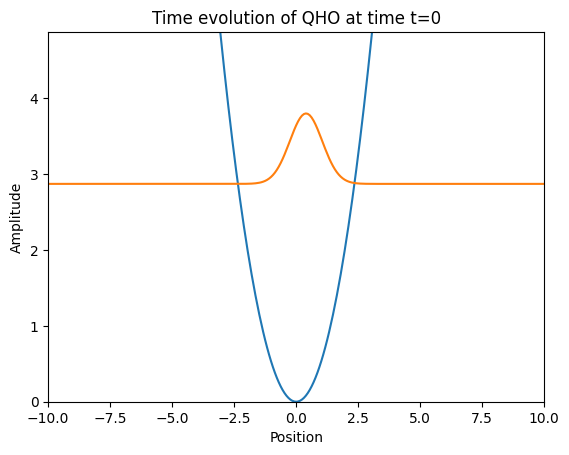

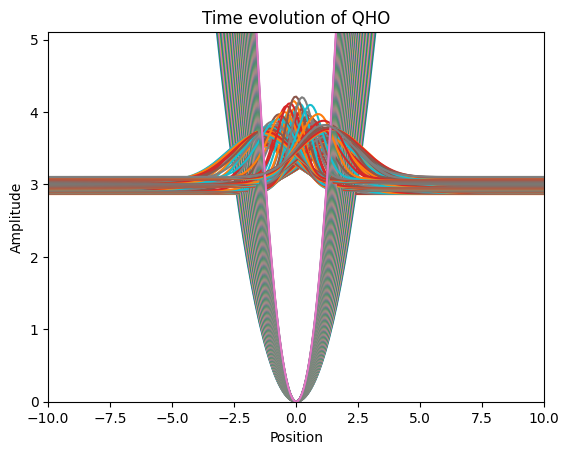

Checking if wfxn is still normalized...
Total probability: 1.0


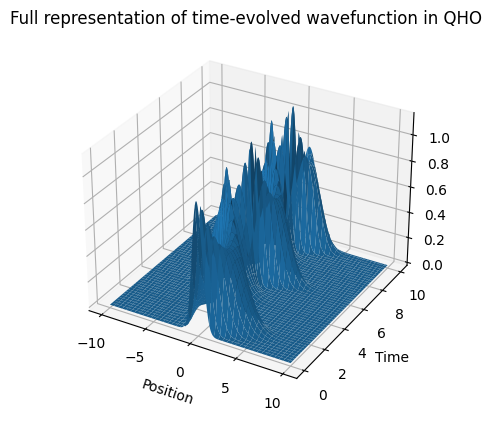

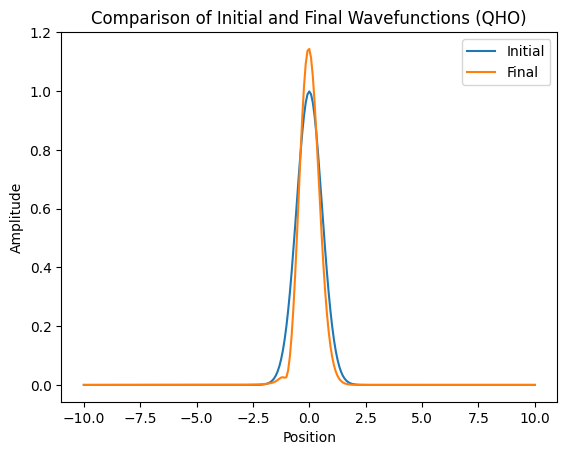

In [6]:
# Applying general Split Operator method to solve TDSE

# Setting up kinetic energy matrix
# 3-pt formula for second derivative
lower_diag = np.ones(N-1)
main_diag = -2*np.ones(N) 
upper_diag = np.ones(N-1)
Tfac=1/(dx**2)

T=-0.5*Tfac*nm.tridiag(lower_diag,main_diag,upper_diag)
U,exp_T=DiagForm(T,dt)

# Allocating and initializing wavefunction
wfxn_sol=np.zeros([N,nt],dtype=complex)
wfxn_sol[:,0]=wfxn

### For time-dependent potentials ###
if type(w)==np.ndarray:
    # Plotting time evolution of potential
    plt.figure()
    for j in range(nt-1):
        wfxnPlot(V[j,:],np.ones([N,1])*-1*avg_H[j],x,L,avg_H[j])
        plt.title('Time evolution of potential')
    plt.show()
    
    # Solving TDSE using split operator
    for j in range(nt-1):
        wfxn_sol[:,j+1]=SplitOp(V[j,:],exp_T,U,wfxn_sol[:,j],dt)

    # Displaying results #
    
    # Plotting one wavefunction inside one potential
    plt.figure() 
    d=2 # Grid point number
    d_time=(10/nt)*(d+1) # Calculation of the time with respect to boundaries
    wfxnPlot(V[d,:],wfxn_sol[:,d],x,L,avg_H[d])
    plt.title('Time evolution of QHO at time t=%i'%d_time)
    plt.show()
    
    # Plotting all timesteps at once on the same plot
    plt.figure()
    for j in range(nt-1):
        wfxnPlot(V[j,:],wfxn_sol[:,j],x,L,avg_H[j])
        plt.title('Time evolution of QHO')
    plt.show()

### For time-independent potentials ###
elif type(w)==int:
    V=np.squeeze(np.asarray(V)) # Converting outer product into scalar array
    
    # Solving TDSE using split operator
    for j in range(nt-1):
        wfxn_sol[:,j+1]=SplitOp(V,exp_T,U,wfxn_sol[:,j],dt)
    
    # Displaying results #
    
    # Plotting initial wavefunction inside initial potential
    plt.figure()
    wfxnPlot(V,wfxn_sol[:,0],x,L,avg_H)
    plt.title('Wavefunction of QHO at time t=0')
    plt.show()
    
    # Plotting all timesteps at once on the same plot
    plt.figure()
    for j in range(nt-1):
        wfxnPlot(V,wfxn_sol[:,j],x,L,avg_H)
        plt.title('Time evolution of QHO')
    plt.show()

# Checking if time-evolution retained normalization of function at the end
# This allows us to validate the model and ensure it is not broken
print(r"Checking if wfxn is still normalized...")
S=nm.simpson(N,x,wfxn_sol[:,-1]*np.conj(wfxn_sol[:,-1]),-L,L)
print("Total probability:",'{:,.5}'.format(np.real(S)))

# Other useful plots
miscPlots(x,t,wfxn_sol)

### FFT Split Operator

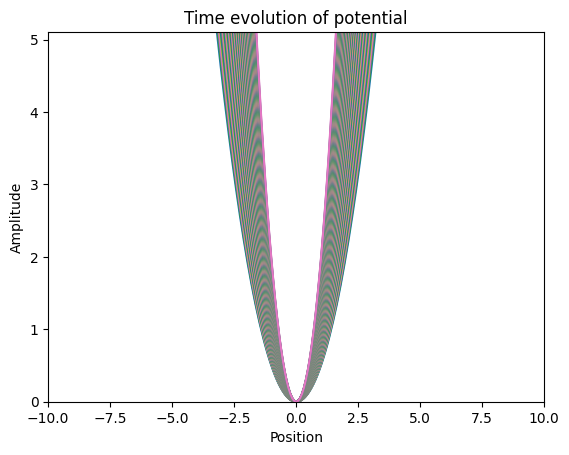

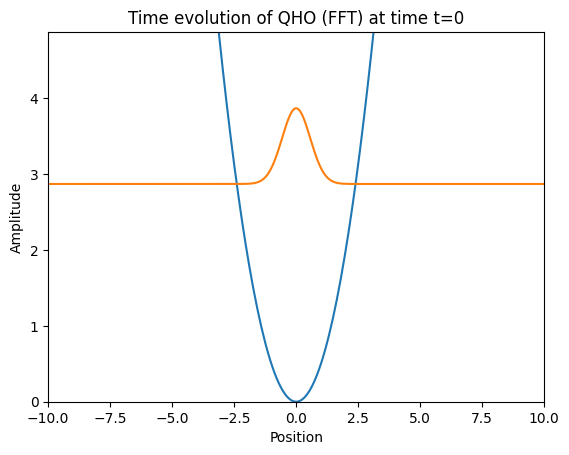

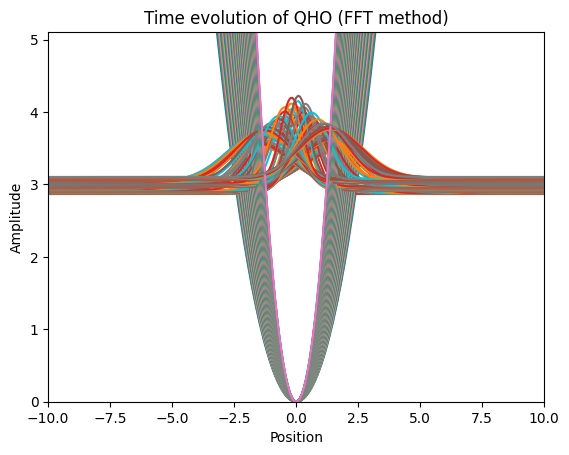

Checking if wfxn is still normalized...
Total probability: 1.0


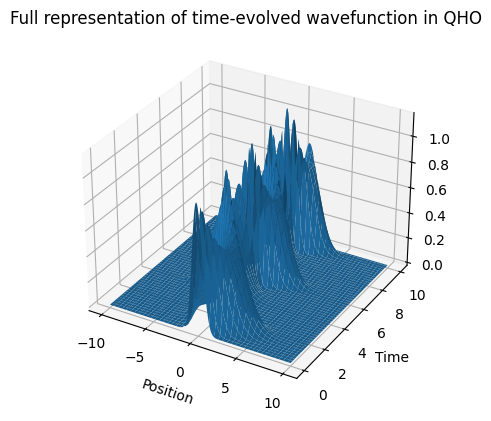

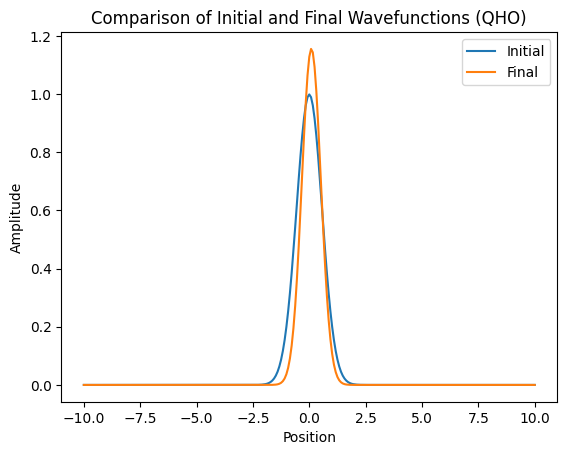

In [8]:
# Applying FFT Split Operator method to solve TDSE

# Defining kinetic energy in k-space
exp_k=np.exp(-0.5j*dt*k**2)

# Allocating and initializing wavefunction
wfxn_sol=np.zeros([N,nt],dtype=complex)
wfxn_sol[:,0]=wfxn

### For time-dependent potentials ###
if type(w)==np.ndarray:
    # Plotting time evolution of potential
    plt.figure()
    for j in range(nt-1):
        wfxnPlot(V[j,:],np.ones([N,1])*-1*avg_H[j],x,L,avg_H[j])
        plt.title('Time evolution of potential')
    plt.show()
    
    # Solving TDSE using fft split operator
    for j in range(nt-1):
        wfxn_sol[:,j+1]=SplitFFT(V[j,:],exp_k,wfxn_sol[:,j],dt)

    # Displaying results #
    
    # Plotting one wavefunction inside one potential
    plt.figure() 
    d=0 # Grid point number
    d_time=(10/nt)*(d+1) # Calculation of the time with respect to boundaries
    wfxnPlot(V[d,:],wfxn_sol[:,d],x,L,avg_H[d])
    plt.title('Time evolution of QHO (FFT) at time t=%i'%d_time)
    plt.show()
    
    # Plotting all timesteps at once on the same plot
    plt.figure()
    for j in range(nt-1):
        wfxnPlot(V[j,:],wfxn_sol[:,j],x,L,avg_H[j])
        plt.title('Time evolution of QHO (FFT method)')
    plt.show()

### For time-independent potentials ###
elif type(w)==int:
    V=np.squeeze(np.asarray(V)) # Converting outer product into scalar array
    
    # Solving TDSE using fft split operator
    for j in range(nt-1):
        wfxn_sol[:,j+1]=SplitFFT(V,exp_k,wfxn_sol[:,j],dt)
    
    # Displaying results #
    
    # Plotting initial wavefunction inside initial potential
    plt.figure()
    wfxnPlot(V,wfxn_sol[:,0],x,L,avg_H)
    plt.title('Wavefunction of QHO at time t=0')
    plt.show()
    
    # Plotting all timesteps at once on the same plot
    plt.figure()
    for j in range(nt-1):
        wfxnPlot(V,wfxn_sol[:,j],x,L,avg_H)
        plt.title('Time evolution of QHO (FFT method)')
    plt.show()

# Checking if time-evolution retained normalization of function at the end
# This allows us to validate the model and ensure it is not broken
print(r"Checking if wfxn is still normalized...")
S=nm.simpson(N,x,wfxn_sol[:,-1]*np.conj(wfxn_sol[:,-1]),-L,L)
print("Total probability:",'{:,.5}'.format(np.real(S)))

# Other useful plots
miscPlots(x,t,wfxn_sol)